In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_13211/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/grc/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
# %matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
# base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

# base_dir = '/Users/josh/Documents'
base_dir = '../../../..'
sys.path.append(f'{base_dir}/github_repos')
# data_folder = f'../../data/final'
data_folder = f'../../data/training'
simclr_model_folder = f'../../models/simclr-modelsn'
model_performance_folder = f'../../reports/model-performance'
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition

# Must "pip install -e . in root project directory for this to work"
from GCaMP_ROI_classifier import util, dataset, models, training, augmentation

In [6]:
# !pip install numba
# !pip install copy
# !pip install scipy


## Import unlabeled training data

In [7]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [8]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

data_labeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_unbalanced.h5')

masks_SYT = data_labeled['SYTmasks']
labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
labels_SYT = labels_SYT[non_nan]
masks_SYT = masks_SYT[non_nan]

X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [9]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


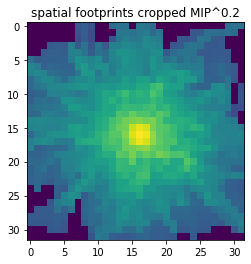

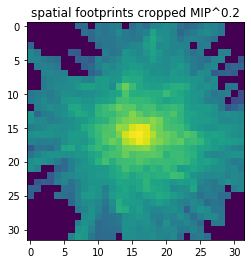

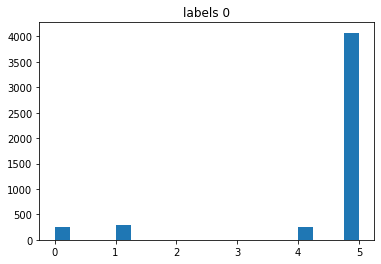

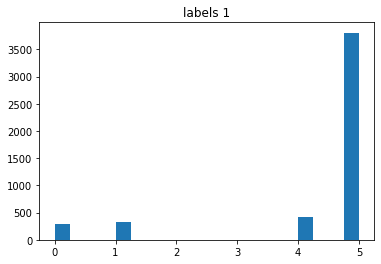

In [10]:
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

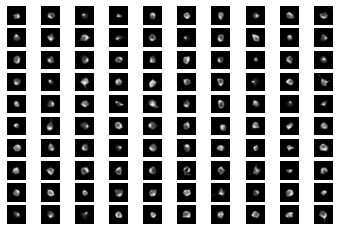

In [11]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [12]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [13]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [14]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

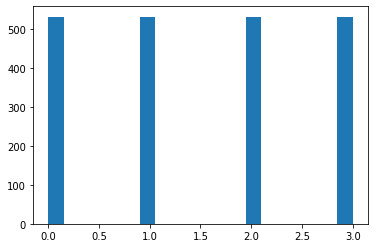

In [15]:
plt.figure()
plt.hist(labels_dup, 20);

In [16]:
images.shape

(2128, 32, 32)

# Train

In [17]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [18]:
# class ModelTackOn(torch.nn.Module):
#     def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
#             super(ModelTackOn, self).__init__()
#             self.base_model = base_model
#             final_base_layer = list(un_modified_model.children())[-1]
#             # final_base_layer = list(list(model.children())[-1].children())[-1]
#             # print(final_base_layer)

#             self.pre_head_fc_lst = []
#             self.post_head_fc_lst = []
#             self.classifier_fc_lst = []

#             self.init_prehead(final_base_layer, pre_head_fc_sizes)
#             self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
#             if classifier_fc_sizes is not None:
#                 self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
#     def init_prehead(self, prv_layer, pre_head_fc_sizes):
#         for i, pre_head_fc in enumerate(pre_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
#             else:
#                 in_features = pre_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
#             self.add_module(f'PreHead_{i}', fc_layer)
#             self.pre_head_fc_lst.append(fc_layer)

# #             if i < len(pre_head_fc_sizes) - 1:
#             non_linearity = torch.nn.ReLU()
#             self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
#             self.pre_head_fc_lst.append(non_linearity)

#     def init_posthead(self, prv_size, post_head_fc_sizes):
#         for i, post_head_fc in enumerate(post_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_size
#             else:
#                 in_features = post_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
#             self.add_module(f'PostHead_{i}', fc_layer)
#             self.post_head_fc_lst.append(fc_layer)

#             if i < len(post_head_fc_sizes) - 1:
#                 non_linearity = torch.nn.ReLU()
#                 self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
#                 self.pre_head_fc_lst.append(non_linearity)
    
#     def init_classifier(self, prv_size, classifier_fc_sizes):
#             for i, classifier_fc in enumerate(classifier_fc_sizes):
#                 if i == 0:
#                     in_features = prv_size
#                 else:
#                     in_features = classifier_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
#             self.add_module(f'Classifier_{i}', fc_layer)
#             self.classifier_fc_lst.append(fc_layer)

#     def reinit_classifier(self):
#         for i_layer, layer in enumerate(self.classifier_fc_lst):
#             layer.reset_parameters()
    
# #     def forward(self, X):
# #         interim = self.base_model(X)
# #         interim = self.get_head(interim)
# #         interim = self.get_latent(interim)
# #         return interim

#     def forward_classifier(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.classify(interim)
#         return interim

#     def forward_latent(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim


#     def get_head(self, base_out):
#         # print('base_out', base_out.shape)
#         head = base_out
#         for pre_head_layer in self.pre_head_fc_lst:
#           # print('pre_head_layer', pre_head_layer.in_features)
#           head = pre_head_layer(head)
#           # print('head', head.shape)
#         return head

#     def get_latent(self, head):
#         latent = head
#         for post_head_layer in self.post_head_fc_lst:
#             latent = post_head_layer(latent)
#         return latent

#     def classify(self, head):
#         logit = head
#         for classifier_layer in self.classifier_fc_lst:
#             logit = classifier_layer(logit)
#         return logit

#     def set_pre_head_grad(self, requires_grad=True):
#         for layer in self.pre_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad
                
#     def set_post_head_grad(self, requires_grad=True):
#         for layer in self.post_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def set_classifier_grad(self, requires_grad=True):
#         for layer in self.classifier_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def prep_contrast(self):
#         self.set_pre_head_grad(requires_grad=True)
#         self.set_post_head_grad(requires_grad=True)
#         self.set_classifier_grad(requires_grad=False)

#     def prep_classifier(self):
#         self.set_pre_head_grad(requires_grad=False)
#         self.set_post_head_grad(requires_grad=False)
#         self.set_classifier_grad(requires_grad=True)


In [19]:
from GCaMP_ROI_classifier.vicreg import main_vicreg as mvr
from GCaMP_ROI_classifier.vicreg.main_vicreg import *
from GCaMP_ROI_classifier.vicreg import augmentations as vraug

In [20]:
from pathlib import Path
import argparse
import json
import math
import os
import sys
import time

import torch
import torch.nn.functional as F
from torch import nn, optim
import torch.distributed as dist
import torchvision.datasets as datasets

import GCaMP_ROI_classifier.vicreg.augmentations as aug
from GCaMP_ROI_classifier.vicreg.distributed import init_distributed_mode

import GCaMP_ROI_classifier.vicreg.resnet

parser = argparse.ArgumentParser('VICReg training script', parents=[mvr.get_arguments()])
args = parser.parse_args(['--device', 'cuda',
                          '--data-dir', '../../data',
                          '--exp-dir', '../../models/vicreg-models/latent-16',
                          '--batch-size', '800',
                          '--arch', 'resnet18',
                          '--mlp', '512-512-512',
                          '--out-features', '16'
                         ])
args.rank = args.local_rank


In [21]:
args.batch_size

800

In [22]:
from GCaMP_ROI_classifier.dataset import dataset_vicreg

In [23]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     augmentation.WarpPoints(r=[0, 1],
#                             cx=[-0.5, 0.5],
#                             cy=[-0.5, 0.5], 
#                             dx=[-0.3, 0.0], 
#                             dy=[-0.3, 0.0], 
#                             n_warps=5,
#                             prob=1.0,
#                             img_size_in=[36, 36],
#                             img_size_out=[224, 224]),

    
#     augmentation.TileChannels(dim=0, n_channels=3),
# #     torchvision.transforms.Resize(size=(224,224), 
# #                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
# )
    

# scripted_transforms = torch.jit.script(transforms)


import torchvision.transforms    

transforms = torch.nn.Sequential(
#     augmentation.Horizontal_stripe_scale(alpha_min_max=(0.5,1), im_size=(36,36), p=0.25),
#     augmentation.Horizontal_stripe_shift(alpha_min_max=(0,6), im_size=(36,36), p=0.25),
    
    torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
                                        scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
                                        shear=(-15, 15, -15, 15),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
                                    scaler_bounds=(10**(4), 10**(6)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.00015,
                                    prob=1),
    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     augmentation.WarpPoints(r=[0, 1],
#                             cx=[-0.5, 0.5], 
#                             cy=[-0.5, 0.5], 
#                             dx=[-0.3, 0.0], 
#                             dy=[-0.3, 0.0], 
#                             n_warps=2,
#                             prob=1.0,
#                             img_size_in=[36, 36],
#                             img_size_out=[224, 224]),
    
#     vraug.Solarize(p=0),
#     augmentation.Horizontal_stripe_scale(alpha_min_max=(0.5,1), im_size=(36,36), p=0.25),
#     augmentation.Horizontal_stripe_shift(alpha_min_max=(0,6), im_size=(36,36), p=0.25),
    
    augmentation.TileChannels(dim=0, n_channels=3),
    
)
    

scripted_transforms = torch.jit.script(transforms)

In [24]:
# args.rank, args.world_size

In [25]:
# import os
# import sys
# import tempfile
# import torch
# import torch.distributed as dist
# import torch.nn as nn
# import torch.optim as optim
# import torch.multiprocessing as mp

# from torch.nn.parallel import DistributedDataParallel as DDP

# def setup(rank, world_size):
#     os.environ['MASTER_ADDR'] = 'localhost'
#     os.environ['MASTER_PORT'] = '12355'

#     # initialize the process group
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)

# def cleanup():
#     dist.destroy_process_group()

# setup(args.rank, args.world_size)

In [26]:
# args.rank = args.local_rank
args.rank = 0

In [27]:
masks_cat.shape[0]//args.batch_size+1

890

In [28]:
from tqdm.notebook import tqdm, trange

torch.backends.cudnn.benchmark = True
# mvr.init_distributed_mode(args)
print(args)
gpu = torch.device(args.device)

if args.rank == 0:
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    stats_file = open(args.exp_dir / "stats.txt", "a", buffering=1)
    print(" ".join(sys.argv))
    print(" ".join(sys.argv), file=stats_file)

# transforms = aug.TrainTransform()

dataset = dataset_vicreg(
                                torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms, scripted_transforms],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
# dataset = datasets.ImageFolder(args.data_dir / "training", transforms)
# sampler = torch.utils.data.distributed.DistributedSampler(dataset, shuffle=True)
sampler = torch.utils.data.RandomSampler(dataset)
assert args.batch_size % args.world_size == 0
per_device_batch_size = args.batch_size // args.world_size
# loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=per_device_batch_size,
# #     num_workers=args.num_workers,
# #     pin_memory=True,
#     sampler=sampler,
# )

loader = torch.utils.data.DataLoader( dataset,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=15,
                                                persistent_workers=True,
                                                prefetch_factor=3
                                                )

model = mvr.VICReg(args).to(DEVICE)#cuda(gpu)
# model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
# model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])

Namespace(arch='resnet18', base_lr=0.2, batch_size=800, cov_coeff=1.0, data_dir=PosixPath('../../data'), device='cuda', dist_url='env://', epochs=100, exp_dir=PosixPath('../../models/vicreg-models/latent-16'), local_rank=-1, log_freq_time=60, mlp='512-512-512', num_workers=10, out_features='16', rank=0, sim_coeff=25.0, std_coeff=25.0, wd=1e-06, world_size=1)
/home/joz608/.conda/envs/grc/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joz608/.local/share/jupyter/runtime/kernel-304b47ef-8e86-4222-b480-aeabea157453.json
0.weight
1.weight
1.bias
4.0.conv1.weight
4.0.bn1.weight
4.0.bn1.bias
4.0.conv2.weight
4.0.bn2.weight
4.0.bn2.bias
4.1.conv1.weight
4.1.bn1.weight
4.1.bn1.bias
4.1.conv2.weight
4.1.bn2.weight
4.1.bn2.bias
5.0.conv1.weight
5.0.bn1.weight
5.0.bn1.bias
5.0.conv2.weight
5.0.bn2.weight
5.0.bn2.bias
5.0.downsample.0.weight
5.0.downsample.1.weight
5.0.downsample.1.bias
5.1.conv1.weight
5.1.bn1.weight
5.1.bn1.bias
5.1.conv2.weight
5.1.bn2.weight
5.1.bn2.bias
6.0.conv1.w

In [29]:
dataset[ii][0].shape

torch.Size([3, 36, 36])

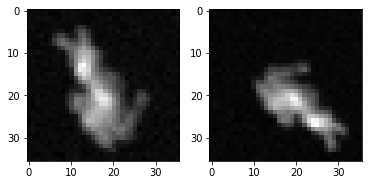

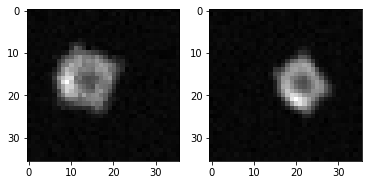

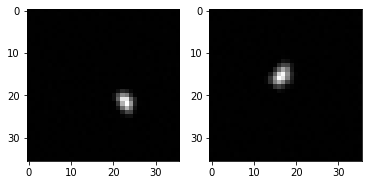

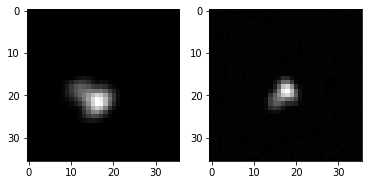

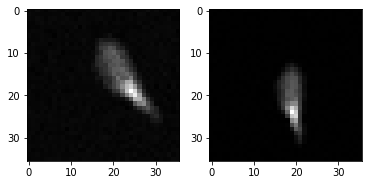

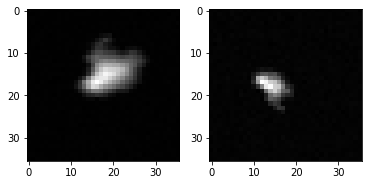

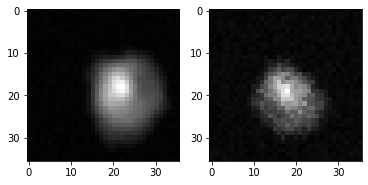

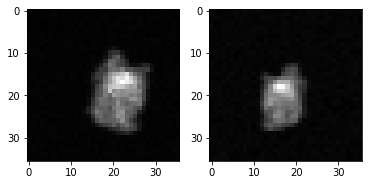

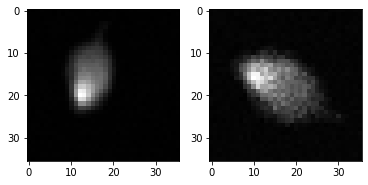

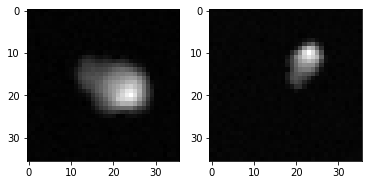

In [30]:
idx_rand = np.random.randint(0,len(dataset), 10)
for ii in idx_rand:
    fig, axs = plt.subplots(1,2)
    # print(dataset_train[ii][0][0][0].shape)
    axs[0].imshow(np.transpose(dataset[ii][0], [1,2,0]))
    axs[1].imshow(np.transpose(dataset[ii][1], [1,2,0]))

In [31]:
optimizer = mvr.LARS(
    model.parameters(),
    lr=0,
    weight_decay=args.wd,
    weight_decay_filter=exclude_bias_and_norm,
    lars_adaptation_filter=exclude_bias_and_norm,
)

if (args.exp_dir / "model.pth").is_file():
    if args.rank == 0:
        print("resuming from checkpoint")
    ckpt = torch.load(args.exp_dir / "model.pth", map_location="cpu")
    start_epoch = ckpt["epoch"]
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
else:
    start_epoch = 0

resuming from checkpoint


In [32]:
start_time = last_logging = time.time()
scaler = torch.cuda.amp.GradScaler()
for epoch in trange(start_epoch, args.epochs):
#     sampler.set_epoch(epoch)
#     for step, ((x, y), _) in enumerate(loader, start=epoch * len(loader)):
    for step, (x, y, _) in tqdm(enumerate(loader, start=epoch * len(loader)), total=len(loader)+1):
        x = x.cuda(gpu, non_blocking=True)
        y = y.cuda(gpu, non_blocking=True)
#         x = x.to(DEVICE)
#         y = y.to(DEVICE)

        lr = mvr.adjust_learning_rate(args, optimizer, loader, step)

        optimizer.zero_grad()
#         with torch.cuda.amp.autocast():
        loss = model.forward(x, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        current_time = time.time()
        if args.rank == 0 and current_time - last_logging > args.log_freq_time:
            stats = dict(
                epoch=epoch,
                step=step,
                loss=loss.item(),
                time=int(current_time - start_time),
                lr=lr,
            )
            print(json.dumps(stats))
            print(json.dumps(stats), file=stats_file)
            last_logging = current_time
    if args.rank == 0:
        state = dict(
            epoch=epoch + 1,
            model=model.state_dict(),
            optimizer=optimizer.state_dict(),
        )
        torch.save(state, args.exp_dir / "model.pth")
if args.rank == 0:
    torch.save(model.module.backbone.state_dict(), args.exp_dir / "resnet18.pth")
    

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 2, "step": 2179, "loss": 13.755374908447266, "time": 60, "lr": 0.1530196629213483}
{"epoch": 2, "step": 2632, "loss": 13.169602394104004, "time": 120, "lr": 0.18483146067415732}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 3, "step": 3067, "loss": 12.592954635620117, "time": 180, "lr": 0.21537921348314606}
{"epoch": 3, "step": 3520, "loss": 12.04804801940918, "time": 240, "lr": 0.24719101123595505}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 4, "step": 3964, "loss": 11.819694519042969, "time": 300, "lr": 0.27837078651685393}
{"epoch": 4, "step": 4419, "loss": 12.084668159484863, "time": 360, "lr": 0.3103230337078652}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 5, "step": 4859, "loss": 11.215771675109863, "time": 420, "lr": 0.3412219101123595}
{"epoch": 5, "step": 5314, "loss": 11.258649826049805, "time": 480, "lr": 0.3731741573033708}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 6, "step": 5758, "loss": 10.603548049926758, "time": 540, "lr": 0.40435393258426966}
{"epoch": 6, "step": 6212, "loss": 10.322221755981445, "time": 600, "lr": 0.4362359550561798}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 7, "step": 6652, "loss": 10.233237266540527, "time": 660, "lr": 0.46713483146067414}
{"epoch": 7, "step": 7107, "loss": 10.024616241455078, "time": 720, "lr": 0.4990870786516854}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 8, "step": 7547, "loss": 9.94681167602539, "time": 780, "lr": 0.5299859550561797}
{"epoch": 8, "step": 8003, "loss": 10.064737319946289, "time": 840, "lr": 0.5620084269662922}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 9, "step": 8445, "loss": 9.720128059387207, "time": 900, "lr": 0.5930477528089888}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 10, "step": 8900, "loss": 9.521378517150879, "time": 962, "lr": 0.625}
{"epoch": 10, "step": 9354, "loss": 9.206963539123535, "time": 1022, "lr": 0.6249505096576303}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 11, "step": 9794, "loss": 9.113825798034668, "time": 1082, "lr": 0.6248081106952038}
{"epoch": 11, "step": 10249, "loss": 9.247488975524902, "time": 1142, "lr": 0.624563139466041}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 12, "step": 10693, "loss": 9.04664421081543, "time": 1202, "lr": 0.6242283829388117}
{"epoch": 12, "step": 11148, "loss": 8.55079460144043, "time": 1262, "lr": 0.6237873611335986}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 13, "step": 11589, "loss": 8.701074600219727, "time": 1322, "lr": 0.6232654003876223}
{"epoch": 13, "step": 12045, "loss": 8.375473976135254, "time": 1382, "lr": 0.6226280212015743}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 14, "step": 12485, "loss": 8.546262741088867, "time": 1443, "lr": 0.6219190622828292}
{"epoch": 14, "step": 12939, "loss": 8.303617477416992, "time": 1503, "lr": 0.6210910552192908}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 15, "step": 13378, "loss": 8.269315719604492, "time": 1563, "lr": 0.6201974515543176}
{"epoch": 15, "step": 13831, "loss": 7.876937389373779, "time": 1623, "lr": 0.6191798234874459}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 16, "step": 14271, "loss": 7.775805473327637, "time": 1683, "lr": 0.6180988108874422}
{"epoch": 16, "step": 14724, "loss": 7.804630756378174, "time": 1743, "lr": 0.6168908786981676}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 17, "step": 15166, "loss": 7.419445037841797, "time": 1803, "lr": 0.6156197574915735}
{"epoch": 17, "step": 15620, "loss": 7.771352767944336, "time": 1863, "lr": 0.6142193920509964}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 18, "step": 16061, "loss": 8.020231246948242, "time": 1923, "lr": 0.6127676236658475}
{"epoch": 18, "step": 16515, "loss": 7.403439998626709, "time": 1983, "lr": 0.6111793231663009}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 19, "step": 16956, "loss": 7.605320930480957, "time": 2043, "lr": 0.6095459234453058}
{"epoch": 19, "step": 17410, "loss": 7.365485191345215, "time": 2103, "lr": 0.6077716447878165}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 20, "step": 17852, "loss": 7.493724346160889, "time": 2163, "lr": 0.6059544151790002}
{"epoch": 20, "step": 18305, "loss": 7.492184638977051, "time": 2223, "lr": 0.6040005554216321}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 21, "step": 18746, "loss": 7.477596282958984, "time": 2283, "lr": 0.6020101517319587}
{"epoch": 21, "step": 19200, "loss": 7.138823986053467, "time": 2343, "lr": 0.5998707013224425}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 22, "step": 19641, "loss": 7.2428507804870605, "time": 2403, "lr": 0.5977053648546324}
{"epoch": 22, "step": 20096, "loss": 7.453543663024902, "time": 2463, "lr": 0.5953819654528987}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 23, "step": 20538, "loss": 6.666008949279785, "time": 2524, "lr": 0.5930387765044152}
{"epoch": 23, "step": 20993, "loss": 7.070002555847168, "time": 2584, "lr": 0.59053871332425}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 24, "step": 21430, "loss": 7.24241828918457, "time": 2644, "lr": 0.5880542797745093}
{"epoch": 24, "step": 21885, "loss": 7.244990825653076, "time": 2704, "lr": 0.5853816053834147}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 25, "step": 22325, "loss": 6.753641128540039, "time": 2764, "lr": 0.5827144766179275}
{"epoch": 25, "step": 22778, "loss": 6.783078670501709, "time": 2824, "lr": 0.579884579747289}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 26, "step": 23217, "loss": 6.776686668395996, "time": 2884, "lr": 0.5770616959554319}
{"epoch": 26, "step": 23673, "loss": 7.224994659423828, "time": 2944, "lr": 0.5740465634185166}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 27, "step": 24116, "loss": 6.577033996582031, "time": 3004, "lr": 0.5710373618943777}
{"epoch": 27, "step": 24570, "loss": 6.5074872970581055, "time": 3064, "lr": 0.5678725679314055}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 28, "step": 25011, "loss": 6.581419944763184, "time": 3124, "lr": 0.5647209586028765}
{"epoch": 28, "step": 25466, "loss": 6.880072593688965, "time": 3184, "lr": 0.5613903217538673}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 29, "step": 25907, "loss": 6.384661674499512, "time": 3244, "lr": 0.5580866110920655}
{"epoch": 29, "step": 26361, "loss": 6.444520950317383, "time": 3304, "lr": 0.5546088702742102}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 30, "step": 26804, "loss": 6.535930156707764, "time": 3364, "lr": 0.5511414840668646}
{"epoch": 30, "step": 27259, "loss": 6.958308696746826, "time": 3424, "lr": 0.5475052872112307}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 31, "step": 27700, "loss": 6.707093238830566, "time": 3485, "lr": 0.5439096371972482}
{"epoch": 31, "step": 28154, "loss": 6.822639465332031, "time": 3545, "lr": 0.5401357825284325}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 32, "step": 28594, "loss": 6.59050178527832, "time": 3605, "lr": 0.5364095158432213}
{"epoch": 32, "step": 29049, "loss": 6.3072123527526855, "time": 3665, "lr": 0.5324861991293417}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 33, "step": 29490, "loss": 6.461007118225098, "time": 3725, "lr": 0.5286168272267777}
{"epoch": 33, "step": 29946, "loss": 6.171257019042969, "time": 3785, "lr": 0.524547967149382}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 34, "step": 30387, "loss": 5.926836013793945, "time": 3845, "lr": 0.5205485178467886}
{"epoch": 34, "step": 30841, "loss": 6.354310989379883, "time": 3905, "lr": 0.5163662624651149}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 35, "step": 31283, "loss": 6.458440780639648, "time": 3965, "lr": 0.5122325383599124}
{"epoch": 35, "step": 31739, "loss": 6.188987731933594, "time": 4025, "lr": 0.5079050893264152}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 36, "step": 32183, "loss": 6.457777500152588, "time": 4085, "lr": 0.5036315490463084}
{"epoch": 36, "step": 32640, "loss": 6.202951431274414, "time": 4145, "lr": 0.4991724653936035}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 37, "step": 33082, "loss": 6.290653705596924, "time": 4205, "lr": 0.4948027716500826}
{"epoch": 37, "step": 33539, "loss": 6.2918596267700195, "time": 4265, "lr": 0.49022729427251627}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 38, "step": 33977, "loss": 6.068689346313477, "time": 4326, "lr": 0.4857885344044161}
{"epoch": 38, "step": 34431, "loss": 5.994080066680908, "time": 4386, "lr": 0.48113376837732075}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 39, "step": 34870, "loss": 6.009289741516113, "time": 4446, "lr": 0.47658202716806397}
{"epoch": 39, "step": 35325, "loss": 6.233225345611572, "time": 4506, "lr": 0.471813172411721}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 40, "step": 35769, "loss": 5.692772388458252, "time": 4566, "lr": 0.46711078383466426}
{"epoch": 40, "step": 36224, "loss": 6.0860185623168945, "time": 4626, "lr": 0.4622433640260604}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 41, "step": 36666, "loss": 6.33640718460083, "time": 4686, "lr": 0.45746943234922044}
{"epoch": 41, "step": 37121, "loss": 5.683868408203125, "time": 4746, "lr": 0.4525096972343253}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 42, "step": 37567, "loss": 6.125827789306641, "time": 4806, "lr": 0.4476048807809995}
{"epoch": 42, "step": 38023, "loss": 5.89216947555542, "time": 4866, "lr": 0.44254746124217614}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 43, "step": 38464, "loss": 5.761366367340088, "time": 4926, "lr": 0.4376169159338929}
{"epoch": 43, "step": 38920, "loss": 5.965749263763428, "time": 4986, "lr": 0.43247941990370403}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 44, "step": 39363, "loss": 6.264535427093506, "time": 5046, "lr": 0.4274517177537212}
{"epoch": 44, "step": 39818, "loss": 5.960968017578125, "time": 5106, "lr": 0.42225181347572216}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 45, "step": 40258, "loss": 5.646816253662109, "time": 5166, "lr": 0.41719017036948475}
{"epoch": 45, "step": 40712, "loss": 5.750655651092529, "time": 5227, "lr": 0.4119349085314905}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 46, "step": 41152, "loss": 5.787010192871094, "time": 5287, "lr": 0.40681169827237057}
{"epoch": 46, "step": 41607, "loss": 5.594985008239746, "time": 5347, "lr": 0.40148441043114214}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 47, "step": 42046, "loss": 5.609798908233643, "time": 5407, "lr": 0.39631767099890963}
{"epoch": 47, "step": 42500, "loss": 5.843646049499512, "time": 5467, "lr": 0.39094837148940004}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 48, "step": 42941, "loss": 5.811058521270752, "time": 5527, "lr": 0.38570908334111886}
{"epoch": 48, "step": 43394, "loss": 5.526108741760254, "time": 5587, "lr": 0.38030453857954893}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 49, "step": 43836, "loss": 5.625335693359375, "time": 5647, "lr": 0.37501068182327296}
{"epoch": 49, "step": 44291, "loss": 5.692573547363281, "time": 5707, "lr": 0.3695416154383767}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 50, "step": 44731, "loss": 5.874494552612305, "time": 5767, "lr": 0.3642356476493831}
{"epoch": 50, "step": 45186, "loss": 5.554622173309326, "time": 5827, "lr": 0.35873270754646125}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 51, "step": 45629, "loss": 5.6461896896362305, "time": 5888, "lr": 0.353360835072931}
{"epoch": 51, "step": 46084, "loss": 5.388542175292969, "time": 5948, "lr": 0.3478307218961901}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 52, "step": 46529, "loss": 5.541588306427002, "time": 6008, "lr": 0.3424113504396839}
{"epoch": 52, "step": 46982, "loss": 5.532383918762207, "time": 6068, "lr": 0.3368853015703232}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 53, "step": 47424, "loss": 5.5816121101379395, "time": 6128, "lr": 0.3314861014095338}
{"epoch": 53, "step": 47877, "loss": 5.676212310791016, "time": 6188, "lr": 0.3259467230408979}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 54, "step": 48321, "loss": 5.622535705566406, "time": 6248, "lr": 0.3205133640896435}
{"epoch": 54, "step": 48777, "loss": 5.796357154846191, "time": 6308, "lr": 0.31493074230407364}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 55, "step": 49220, "loss": 5.573363304138184, "time": 6368, "lr": 0.3095066091256462}
{"epoch": 55, "step": 49675, "loss": 5.6997199058532715, "time": 6428, "lr": 0.30393660111249454}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 56, "step": 50119, "loss": 5.606219291687012, "time": 6488, "lr": 0.29850396374331867}
{"epoch": 56, "step": 50573, "loss": 5.61414098739624, "time": 6548, "lr": 0.2929534690975077}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 57, "step": 51016, "loss": 5.205959320068359, "time": 6608, "lr": 0.28754351353634033}
{"epoch": 57, "step": 51471, "loss": 5.263490676879883, "time": 6668, "lr": 0.2819949691317279}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 58, "step": 51914, "loss": 5.560117721557617, "time": 6728, "lr": 0.27660217417703886}
{"epoch": 58, "step": 52368, "loss": 5.35495138168335, "time": 6789, "lr": 0.2710868279146794}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 59, "step": 52811, "loss": 5.501776695251465, "time": 6849, "lr": 0.2657178522240931}
{"epoch": 59, "step": 53266, "loss": 5.263855934143066, "time": 6909, "lr": 0.26021825643643887}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 60, "step": 53710, "loss": 5.293889045715332, "time": 6969, "lr": 0.25486775067289597}
{"epoch": 60, "step": 54164, "loss": 5.2082319259643555, "time": 7029, "lr": 0.2494149199639663}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 61, "step": 54607, "loss": 5.1948652267456055, "time": 7089, "lr": 0.24411356878475216}
{"epoch": 61, "step": 55063, "loss": 5.25407600402832, "time": 7149, "lr": 0.23867832427462535}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 62, "step": 55506, "loss": 5.239318370819092, "time": 7209, "lr": 0.233420723938168}
{"epoch": 62, "step": 55962, "loss": 5.259840965270996, "time": 7269, "lr": 0.2280338854232564}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 63, "step": 56407, "loss": 5.105934143066406, "time": 7329, "lr": 0.22280312279822953}
{"epoch": 63, "step": 56863, "loss": 5.384852409362793, "time": 7389, "lr": 0.21747151670621723}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 64, "step": 57306, "loss": 5.033037185668945, "time": 7449, "lr": 0.21232109628838708}
{"epoch": 64, "step": 57761, "loss": 5.152608871459961, "time": 7509, "lr": 0.2070627555234231}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 65, "step": 58205, "loss": 5.141822814941406, "time": 7569, "lr": 0.20196399151563593}
{"epoch": 65, "step": 58660, "loss": 5.275664329528809, "time": 7629, "lr": 0.1967737933911023}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 66, "step": 59104, "loss": 5.464588165283203, "time": 7689, "lr": 0.19174468348690843}
{"epoch": 66, "step": 59561, "loss": 5.111567497253418, "time": 7749, "lr": 0.1866066813288102}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 67, "step": 60004, "loss": 5.125502109527588, "time": 7809, "lr": 0.18166476436877071}
{"epoch": 67, "step": 60459, "loss": 5.23567008972168, "time": 7870, "lr": 0.17663020828996312}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 68, "step": 60904, "loss": 5.376784801483154, "time": 7930, "lr": 0.1717482389981946}
{"epoch": 68, "step": 61359, "loss": 5.15764045715332, "time": 7990, "lr": 0.16680100277424936}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 69, "step": 61804, "loss": 5.130082130432129, "time": 8050, "lr": 0.1620074621309468}
{"epoch": 69, "step": 62259, "loss": 5.0035319328308105, "time": 8110, "lr": 0.15715370940214973}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 70, "step": 62701, "loss": 5.3567280769348145, "time": 8170, "lr": 0.1524860872151035}
{"epoch": 70, "step": 63156, "loss": 5.10996150970459, "time": 8230, "lr": 0.147731523474062}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 71, "step": 63601, "loss": 5.151145935058594, "time": 8290, "lr": 0.14313229520679785}
{"epoch": 71, "step": 64056, "loss": 5.105125904083252, "time": 8350, "lr": 0.1384831657713607}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 72, "step": 64501, "loss": 5.0325117111206055, "time": 8410, "lr": 0.13398990360441412}
{"epoch": 72, "step": 64956, "loss": 4.97258186340332, "time": 8470, "lr": 0.12945200071092994}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 73, "step": 65398, "loss": 4.976225852966309, "time": 8530, "lr": 0.12509965224732242}
{"epoch": 73, "step": 65854, "loss": 5.165590763092041, "time": 8590, "lr": 0.12066858018753376}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 74, "step": 66297, "loss": 5.269434928894043, "time": 8650, "lr": 0.11642267476327675}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 75, "step": 66750, "loss": 4.979923248291016, "time": 8712, "lr": 0.1121422431009835}
{"epoch": 75, "step": 67204, "loss": 5.010767459869385, "time": 8772, "lr": 0.10791591684380751}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 76, "step": 67648, "loss": 5.135192394256592, "time": 8832, "lr": 0.10384550498942291}
{"epoch": 76, "step": 68105, "loss": 4.920801162719727, "time": 8892, "lr": 0.09972210465881165}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 77, "step": 68549, "loss": 5.129103660583496, "time": 8952, "lr": 0.09578155219000468}
{"epoch": 77, "step": 69004, "loss": 5.1249847412109375, "time": 9012, "lr": 0.09181166242752968}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 78, "step": 69447, "loss": 5.21253776550293, "time": 9072, "lr": 0.08801408127202136}
{"epoch": 78, "step": 69902, "loss": 4.822004318237305, "time": 9132, "lr": 0.08418428564936821}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 79, "step": 70345, "loss": 4.871492385864258, "time": 9192, "lr": 0.08052543794330903}
{"epoch": 79, "step": 70800, "loss": 5.055168151855469, "time": 9252, "lr": 0.0768404867282372}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 80, "step": 71244, "loss": 5.009817123413086, "time": 9312, "lr": 0.073317056254671}
{"epoch": 80, "step": 71700, "loss": 4.810598373413086, "time": 9372, "lr": 0.0697740037129469}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 81, "step": 72143, "loss": 5.221271991729736, "time": 9432, "lr": 0.06640639343305121}
{"epoch": 81, "step": 72600, "loss": 4.819989204406738, "time": 9493, "lr": 0.06301031639991511}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 82, "step": 73044, "loss": 5.207296848297119, "time": 9553, "lr": 0.059787695178612724}
{"epoch": 82, "step": 73500, "loss": 4.990496635437012, "time": 9613, "lr": 0.056557851501292916}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 83, "step": 73945, "loss": 5.174034595489502, "time": 9673, "lr": 0.053484935167125325}
{"epoch": 83, "step": 74401, "loss": 4.8547468185424805, "time": 9733, "lr": 0.05041801375097719}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 84, "step": 74844, "loss": 4.841592311859131, "time": 9793, "lr": 0.047518890952640246}
{"epoch": 84, "step": 75299, "loss": 4.642416000366211, "time": 9853, "lr": 0.04462461438020593}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 85, "step": 75742, "loss": 4.892824649810791, "time": 9913, "lr": 0.04188871915293142}
{"epoch": 85, "step": 76198, "loss": 4.9473724365234375, "time": 9973, "lr": 0.039157967466366135}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 86, "step": 76643, "loss": 4.751227378845215, "time": 10033, "lr": 0.036577470545235996}
{"epoch": 86, "step": 77098, "loss": 4.803164482116699, "time": 10093, "lr": 0.034025992289223934}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 87, "step": 77542, "loss": 5.025123596191406, "time": 10153, "lr": 0.031621778934645677}
{"epoch": 87, "step": 77998, "loss": 4.707204341888428, "time": 10214, "lr": 0.029241350385090386}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 88, "step": 78441, "loss": 4.935288429260254, "time": 10274, "lr": 0.02701563795258672}
{"epoch": 88, "step": 78896, "loss": 4.940202713012695, "time": 10334, "lr": 0.024819454425925844}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 89, "step": 79339, "loss": 4.863804817199707, "time": 10394, "lr": 0.02276930259647482}
{"epoch": 89, "step": 79795, "loss": 4.728198051452637, "time": 10454, "lr": 0.02075044384832915}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 90, "step": 80239, "loss": 4.956202030181885, "time": 10514, "lr": 0.018874469962185638}
{"epoch": 90, "step": 80694, "loss": 4.941599369049072, "time": 10574, "lr": 0.017044498150367134}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 91, "step": 81137, "loss": 4.911435127258301, "time": 10634, "lr": 0.015353279567600166}
{"epoch": 91, "step": 81592, "loss": 4.59151554107666, "time": 10694, "lr": 0.013709731703892765}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 92, "step": 82036, "loss": 4.733535289764404, "time": 10754, "lr": 0.012197738090094086}
{"epoch": 92, "step": 82491, "loss": 4.996529579162598, "time": 10814, "lr": 0.01074286365962993}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 93, "step": 82935, "loss": 5.067117691040039, "time": 10874, "lr": 0.009415893435062515}
{"epoch": 93, "step": 83391, "loss": 4.974620819091797, "time": 10934, "lr": 0.008148828828681799}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 94, "step": 83837, "loss": 4.823732852935791, "time": 10994, "lr": 0.0070038140530960585}
{"epoch": 94, "step": 84293, "loss": 4.967558860778809, "time": 11054, "lr": 0.005929870791334107}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 95, "step": 84736, "loss": 4.925562381744385, "time": 11114, "lr": 0.004980541638183112}
{"epoch": 95, "step": 85192, "loss": 4.9036359786987305, "time": 11175, "lr": 0.004100414933414932}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 96, "step": 85637, "loss": 4.606628894805908, "time": 11235, "lr": 0.0033367161769466925}
{"epoch": 96, "step": 86091, "loss": 5.027503967285156, "time": 11295, "lr": 0.002654721750741293}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 97, "step": 86535, "loss": 4.9801435470581055, "time": 11355, "lr": 0.0020828598382542423}
{"epoch": 97, "step": 86990, "loss": 4.7705535888671875, "time": 11415, "lr": 0.0015945883970697084}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 98, "step": 87434, "loss": 4.767825126647949, "time": 11475, "lr": 0.0012136636388970468}
{"epoch": 98, "step": 87889, "loss": 4.616196632385254, "time": 11535, "lr": 0.0009213327333832814}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 99, "step": 88331, "loss": 4.90744161605835, "time": 11595, "lr": 0.0007324601756674734}
{"epoch": 99, "step": 88786, "loss": 4.686566352844238, "time": 11655, "lr": 0.0006359962656886504}


AttributeError: 'VICReg' object has no attribute 'module'

In [ ]:
X_data = X_labeled_train_SYT.copy()

transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_validation = torch.jit.script(transforms_validation)

dataset_labeled_train = dataset_vicreg(
                                torch.as_tensor(X_data, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_data.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
dataloader_labeled_train = torch.utils.data.DataLoader(dataset_labeled_train,
                                                batch_size=100,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=False,
                                                num_workers=0,
                                                persistent_workers=False,
                                                )

latents = torch.cat([model.projector(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_train)], dim=0)

In [ ]:
latents.shape

In [ ]:
%matplotlib notebook

from basic_neural_processing_modules import similarity, decomposition

pairs = similarity.pairwise_similarity(latents.numpy())

plt.figure()
plt.imshow(pairs)

In [ ]:
# dtp = decomposition.torch_pca(latents)[0]

# plt.figure()
# plt.plot(dtp)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(latents)

In [ ]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.yscale('linear')

In [ ]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

In [ ]:
import umap
# import sns
# sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
fit = umap.UMAP()
%time u = fit.fit_transform(latents)

In [ ]:
import pandas as pd
xy_df = pd.DataFrame(u, columns=['x', 'y'])
xy_df['x_min'] = xy_df['x'].min()
xy_df['x_max'] = xy_df['x'].max()
xy_df['y_min'] = xy_df['y'].min()
xy_df['y_max'] = xy_df['y'].max()

xy_df['x_mm'] = (xy_df['x'] - xy_df['x_min']) / (xy_df['x_max'] - xy_df['x_min'])
xy_df['y_mm'] = (xy_df['y'] - xy_df['y_min']) / (xy_df['y_max'] - xy_df['y_min'])

xy_df['x_mmf'] = np.floor(xy_df['x_mm']*20)
xy_df['y_mmf'] = np.floor(xy_df['y_mm']*20)

xy_df['mmf'] = xy_df['x_mmf'].astype(str) + '_' + xy_df['y_mmf'].astype(str)
smpl_imgs = xy_df.groupby('mmf').sample(1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scl_to_bnd(x, bound_high):
    mx = x.max(axis=0, keepdims=True)
    mn = x.min(axis=0, keepdims=True)
    scl = (x - mn)*(bound_high-1)/(mx - mn)
    return scl, mn, mx

bound_high = 1000
bounded_features = scl_to_bnd(u, bound_high)
inx_lst = list(smpl_imgs.index)
img_lst = X_data[inx_lst]
x = bounded_features[0][inx_lst, 0]
y = bounded_features[0][inx_lst, 1]

In [ ]:
def getImage(img):
    return OffsetImage(img, cmap='gray')

In [ ]:
%matplotlib notebook
# plt.figure()
# plt.scatter(u[:,0], u[:,1])
# plt.title('UMAP');

fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(bounded_features[0][:,0], bounded_features[0][:,1], cmap=plt.get_cmap('tab10'))
ax.scatter(x, y)

for x0, y0, path in zip(x, y, img_lst):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)


In [ ]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


In [ ]:
dataset_labeled_train = dataset_vicreg(
                                torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
dataset_labeled_val = dataset_vicreg(
                                torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
                                                    batch_size=800,
                                                    shuffle=False,
                                                    drop_last=False
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
                                                    batch_size=800,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    )


In [ ]:
model.eval()
model.to(DEVICE)
features_train = torch.cat([model.projector(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_train)], dim=0)
features_val   = torch.cat([model.projector(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_val)], dim=0)


In [ ]:
acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

In [ ]:
from sklearn.model_selection import ShuffleSplit
splitter = ShuffleSplit(n_splits=50)
all_split_inx = list(splitter.split(features_train))

train_X = [features_train[_[0]] for _ in all_split_inx]
train_y = [y_labeled_train[_[0]] for _ in all_split_inx]
# train_y = [y_labeled_train_SYT[_[0]] for _ in all_split_inx]
test_X = [features_train[_[1]] for _ in all_split_inx]
test_y = [y_labeled_train[_[1]] for _ in all_split_inx]
# test_y = [y_labeled_train_SYT[_[1]] for _ in all_split_inx]

%matplotlib inline

c_lst = [1e1, 1e0, 1e-1, 1e-2, 1e-3]

fig, ax = plt.subplots(len(c_lst), 2, figsize=(10,10))
# plt.suptitle(f'{model_file_name}')

for ic, c in enumerate(c_lst):
    train_cms = []
    test_cms = []
    for inx_split in trange(len(train_X)):
        tmp_train_X = train_X[inx_split]
        tmp_train_y = train_y[inx_split]
        
        tmp_test_X = test_X[inx_split]
        tmp_test_y = test_y[inx_split]
        
        logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=c).fit(tmp_train_X, tmp_train_y)
        
        
        
        
        
        proba = logreg.predict_proba(tmp_train_X)

        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_train_y)
        train_cms.append(cm)

#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('train');
        
        proba = logreg.predict_proba(tmp_test_X)
        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_test_y)
        test_cms.append(cm)
        
#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('val');

    sns.heatmap(np.mean(train_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 0])
    ax[ic, 0].set_title(f'train — C:{c}');

    sns.heatmap(np.mean(test_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 1])
    ax[ic, 1].set_title(f'val — C:{c}');

plt.tight_layout()


In [ ]:
break

In [ ]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

# base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)


for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [ ]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [ ]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [ ]:
base_model_frozen

In [ ]:
# unfreeze particular blocks in ResNet model

# #efficient net 
# for name, param in list(model.named_parameters()):
#     print(name)
#     print(name)
#     if name[:10] == 'base_model':
#         if int(name[13]) < 7:
#             param.requires_grad = False
#         elif int(name[13]) >= 7:
#             param.requires_grad = True

# for name, param in list(model.named_parameters()):
#     if param.requires_grad:
#         print(name)


#ResNet18
for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 7:
            param.requires_grad = False
        elif int(name[11]) >= 7:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

## Define augmentation pipeline

In [ ]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
#                                         scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
#                                         shear=(-15, 15, -15, 15),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
#     augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
#                                     scaler_bounds=(10**(4), 10**(6)),
#                                     prob=1,
#                                     base=1000,
#                                     scaling='log'),
#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.00015,
#                                     prob=1),
    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     # torchvision.transforms.Resize(size=(224,224), 
#     #                               interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
#     augmentation.TileChannels(dim=0, n_channels=3),
# )

import torchvision.transforms    

transforms = torch.nn.Sequential(
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    augmentation.WarpPoints(r=[0, 1],
                            cx=[-0.5, 0.5],
                            cy=[-0.5, 0.5], 
                            dx=[-0.3, 0.0], 
                            dy=[-0.3, 0.0], 
                            n_warps=5,
                            prob=1.0,
                            img_size_in=[36, 36],
                            img_size_out=[224, 224]),

    
    augmentation.TileChannels(dim=0, n_channels=3),
#     torchvision.transforms.Resize(size=(224,224), 
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
)
    

scripted_transforms = torch.jit.script(transforms)


In [ ]:
dataset_train = dataset.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(1,2)
    # print(dataset_train[ii][0][0][0].shape)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [ ]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

## Training

In [ ]:
model.to(DEVICE)
model.prep_contrast()

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def get_ds_dl(data, transforms, expand_dim=False):
    setup_ds = dataset.dataset_simCLR(
                                    torch.as_tensor(data, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(data.shape[0]), device='cpu', dtype=torch.float32),


                                    n_transforms=1,
                                    transform=transforms,
                                    class_weights=np.array([1]),
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,

                                    temp_uncertainty=16,
                                    expand_dim=expand_dim
                                    )
    setup_dl = torch.utils.data.DataLoader( setup_ds,
                                            batch_size=1024,
                                            shuffle=False,
                                            drop_last=False,
                                            # pin_memory=True,
                                            # num_workers=16,
                                            # persistent_workers=True,
                                            )

    return setup_ds, setup_dl

In [ ]:
X_labeled_train.shape

In [ ]:
all_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)
no_transforms = torch.nn.Sequential(
)
scale_rsz_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
)
tile_transforms = torch.nn.Sequential(
    augmentation.TileChannels(dim=0, n_channels=3),
)


scripted_all_transforms = torch.jit.script(all_transforms)
scripted_no_transforms = torch.jit.script(no_transforms)
scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
scripted_tile_transform = torch.jit.script(tile_transforms)

In [ ]:
setup_transform = scripted_scale_rsz_transform
run_transform = scripted_tile_transform

setup_ds, setup_dl = get_ds_dl(X_labeled_train, setup_transform, expand_dim=True)
input_xtr = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=True)
input_xtr_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

setup_ds, setup_dl = get_ds_dl(X_labeled_val, setup_transform, expand_dim=True)
input_xval = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_val_SYT, setup_transform, expand_dim=True)
input_xval_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

# print("Starting!")
# tik = time.time()
# ds_run = util.dataset_simCLR(
#                             torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
#                             torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

#                             n_transforms=1,
#                             class_weights=np.array([1]),
#                             transform=run_transform,
#                             DEVICE='cpu',
#                             dtype_X=torch.float32,
#                             dtype_y=torch.int64,

#                             temp_uncertainty=16,
#                             expand_dim=False
#                             )
# dl_run = torch.utils.data.DataLoader( ds_run,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# tok = time.time()

# print(f'Tile Transformation Alone Took: {tok-tik} s to run')

In [ ]:
input_xtr.shape, input_xtr_SYT.shape, input_xval.shape, input_xval_SYT.shape

In [ ]:
# scale_rsz_transforms = torch.nn.Sequential(
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     torchvision.transforms.Resize(size=(224,224),
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR))
# tile_transforms = torch.nn.Sequential(augmentation.TileChannels(dim=0, n_channels=3),)


# scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
# scripted_tile_transform = torch.jit.script(tile_transforms)


# setup_transform = scripted_scale_rsz_transform
# run_transform = scripted_tile_transform



# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)

# setup_ds = util.dataset_simCLR(
#                                 torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
#                                 torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),
#                                 n_transforms=1,
#                                 transform=setup_transform,
#                                 class_weights=np.array([1]),
#                                 DEVICE='cpu',
#                                 dtype_X=torch.float32,
#                                 dtype_y=torch.int64,

#                                 temp_uncertainty=16,
#                                 expand_dim=False
#                                 )
# setup_dl = torch.utils.data.DataLoader( setup_ds,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )


# input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)
# # input_x_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)



In [ ]:
# acc_train_lst, acc_val_lst = [], []
# acc_train_SYT_lst, acc_val_SYT_lst = [], []

# print('A')
# ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
# features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)

# print('B')
# ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
# features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
# features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


# acc_train, acc_val = {}, {}
# acc_train_SYT, acc_val_SYT = {}, {}
# C_toUse = np.array([1e1,1e0,1e-1,1e-2])
# for C in C_toUse:
#     print('C1')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg.fit(features_train, y_labeled_train)
#     acc_train_tmp = logreg.score(features_train, y_labeled_train)
#     acc_train[C] = acc_train_tmp
#     acc_val_tmp = logreg.score(features_val, y_labeled_val)
#     acc_val[C] = acc_val_tmp
    
#     print('C2')
#     logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#     acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#     acc_train_SYT[C] = acc_train_tmp
#     acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#     acc_val_SYT[C] = acc_val_tmp

# acc_train_lst.append(acc_train)
# acc_val_lst.append(acc_val)
# acc_train_SYT_lst.append(acc_train_SYT)
# acc_val_SYT_lst.append(acc_val_SYT)


# losses_train_npy = np.array(losses_train)
# losses_val_npy = np.array(losses_val)
# val_accs_npy = np.array(val_accs)
# acc_npy = np.array(acc)

In [ ]:
# acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
# display(acc_train_df)
# display(acc_val_df)
# display(acc_train_SYT_df)
# display(acc_val_SYT_df)

# acc_train_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train.csv')
# acc_val_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val.csv')
# acc_train_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train_SYT.csv')
# acc_val_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val_SYT.csv')

In [ ]:
# model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient2-only7unfrozen'
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=cpu-reorg-test'
model.forward = model.forward_latent

In [ ]:
l2_alpha = 0.000
n_epochs=300000

acc_train_lst, acc_val_lst = [], []
acc_train_SYT_lst, acc_val_SYT_lst = [], []

for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    
    ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
    features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
    features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    
    ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
    features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
    features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


### Add back in for continuous evaluation of classification performance

#     acc_train, acc_val = {}, {}
#     acc_train_SYT, acc_val_SYT = {}, {}
#     C_toUse = np.array([1e1,1e0,1e-1,1e-2])
#     for C in C_toUse:
#         logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg.fit(features_train, y_labeled_train)
#         acc_train_tmp = logreg.score(features_train, y_labeled_train)
#         acc_train[C] = acc_train_tmp
#         acc_val_tmp = logreg.score(features_val, y_labeled_val)
#         acc_val[C] = acc_val_tmp
        
#         logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#         acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#         acc_train_SYT[C] = acc_train_tmp
#         acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#         acc_val_SYT[C] = acc_val_tmp

#     acc_train_lst.append(acc_train)
#     acc_val_lst.append(acc_val)
#     acc_train_SYT_lst.append(acc_train_SYT)
#     acc_val_SYT_lst.append(acc_val_SYT)

#     acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
    
#     acc_train_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train.csv')
#     acc_train_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train_SYT.csv')
#     acc_val_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val.csv')
#     acc_val_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val_SYT.csv')
    
    
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')
   
    # Add back in for continuous evaluation of classification performance

#     losses_train_npy = np.array(losses_train)
#     losses_val_npy = np.array(losses_val)
#     val_accs_npy = np.array(val_accs)
#     acc_npy = np.array(acc)
    
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_train.npy', losses_train_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_val.npy', losses_val_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_val_accs.npy', val_accs_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_tr_accs.npy', acc_npy)
    

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')